**DSCI100 Project Proposal**

Introduction:
Every day, children and adults around the world suffer from a medical complication known as a stroke. A stroke is when there’s disruption in the blood supply to the brain. Strokes can have serious and potentially life-threatening consequences, as they can lead to brain damage, disability, or even death. There are several factors that contribute to a person’s chances of getting a stroke which include: blood pressure levels, BMI, smoking, physical activity, age, and more. Our project aims to predict the likelihood of someone getting a stroke by examining a person’s blood pressure levels. We want to attempt to answer the following questions: Do abnormal blood pressure levels affect your risks of getting a stroke? Does higher stress levels affect your risks of getting a stroke?

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
stroke <- read_csv("https://raw.githubusercontent.com/Megunight/dsci100-project/main/stroke_prediction_dataset.csv")

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
names(stroke) <- c("patient_id", "patient_name", "age", "gender", "hypertension", "heart_disease", "marital_status",
                  "work_type", "residence_type", "average_glucose_level", "bmi", "smoking_status", "alcohol_intake", "physical_activity",
                  "stroke_history", "family_history_of_stroke", "dietary_habits", "stress_levels", "blood_pressure_levels",
                  "cholesterol_levels", "symptoms", "diagnosis")
head(stroke)

patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
29307,Advika Kota,62,Female,0,0,Single,Private,Urban,91.60,⋯,Social Drinker,High,0,No,Gluten-Free,4.85,132/64,"HDL: 80, LDL: 69",Severe Fatigue,Stroke


In [4]:
#Seven different variables have been selected for use

stroke_selected <- stroke |>
                    select(age,
                           hypertension,
                           stress_levels,
                           work_type,
                           marital_status,
                           residence_type,
                           diagnosis)

In [5]:
stroke_sample <- stroke_selected |>
                sample_n(5000)

Due to the large number of rows in the stroke data set, we decided to sample 5000 random rows from the data set to ensure that our visualizations wouldn't be overwhelmed with data points.

In [6]:
stroke_split <- initial_split(stroke_sample, prop = 0.75, strata = diagnosis)
stroke_training <- training(stroke_split)
stroke_testing <- testing(stroke_split)

stroke_training

age,hypertension,stress_levels,work_type,marital_status,residence_type,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
33,0,5.42,Self-employed,Single,Rural,No Stroke
68,0,9.54,Government Job,Married,Rural,No Stroke
37,0,2.17,Private,Single,Urban,No Stroke
64,0,3.35,Never Worked,Married,Urban,No Stroke
33,0,8.12,Self-employed,Single,Urban,No Stroke
73,0,6.45,Private,Single,Rural,No Stroke
54,1,9.17,Self-employed,Single,Rural,No Stroke
72,0,7.92,Government Job,Married,Urban,No Stroke
65,1,9.34,Private,Married,Rural,No Stroke


In [7]:
stroke_training <- stroke_training |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High"))


stroke_training <- stroke_training |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) |>
    mutate(hypertension = as_factor(hypertension)) |>
    mutate(hypertension = fct_recode(hypertension, "False" = "0", "True" = "1"))


We split the data set into a training set and testing set. After that, we mutated stress levels and age into categories because there are too many values too plot.

In [8]:
stroke_obs <- stroke_training |>
                group_by(diagnosis) |>
                summarise(count = n())
stroke_obs


diagnosis,count
<chr>,<int>
No Stroke,1878
Stroke,1871


This table summarizes the count of the diagnostics of people who have had a stroke or no stroke.

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


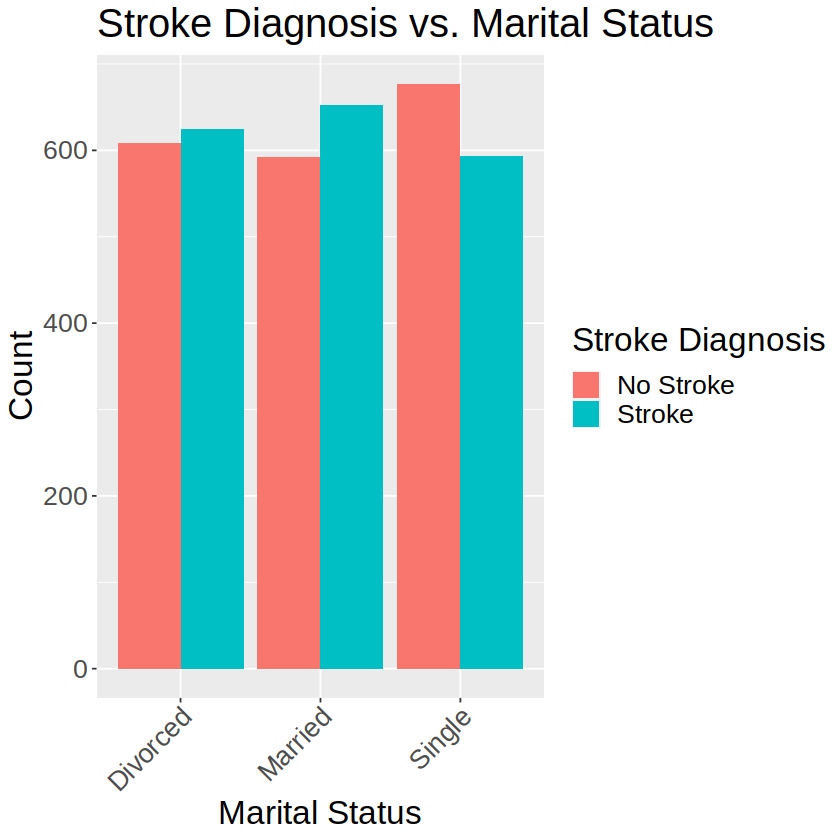

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


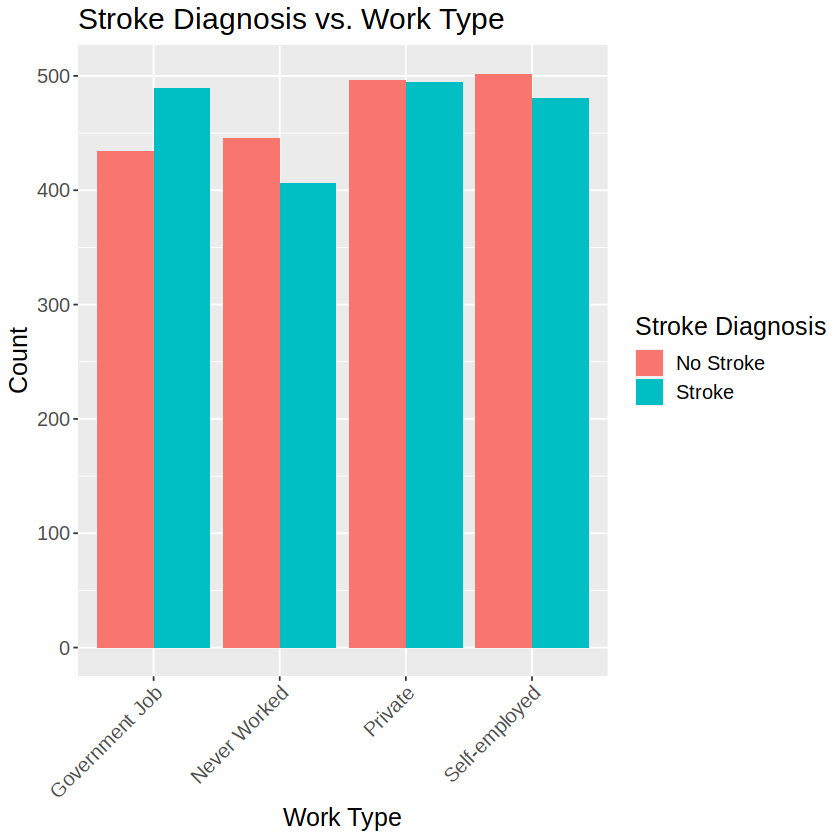

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


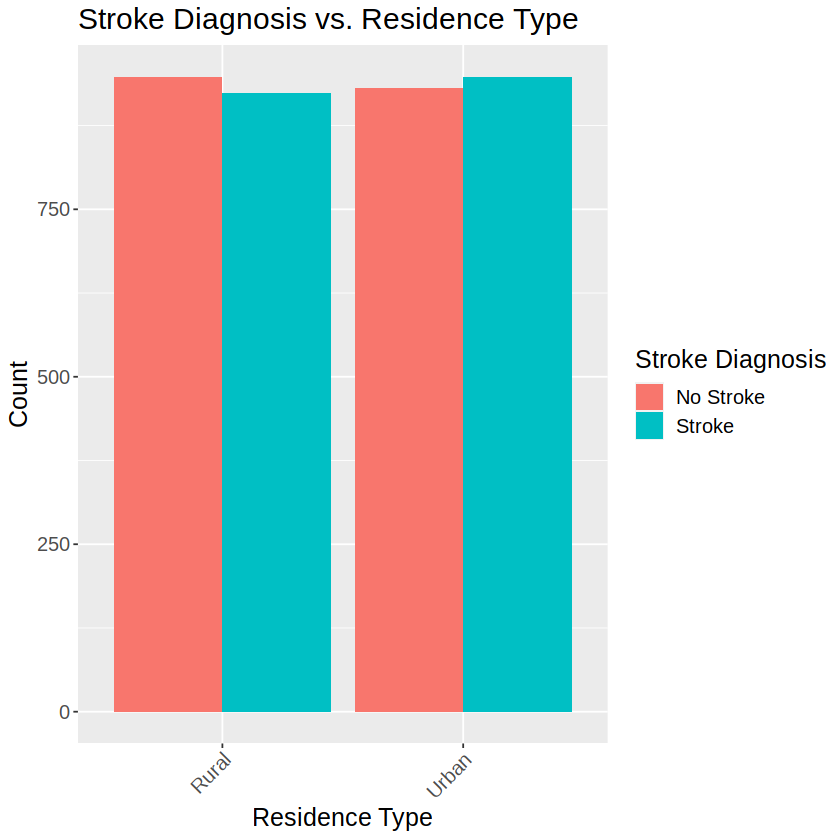

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


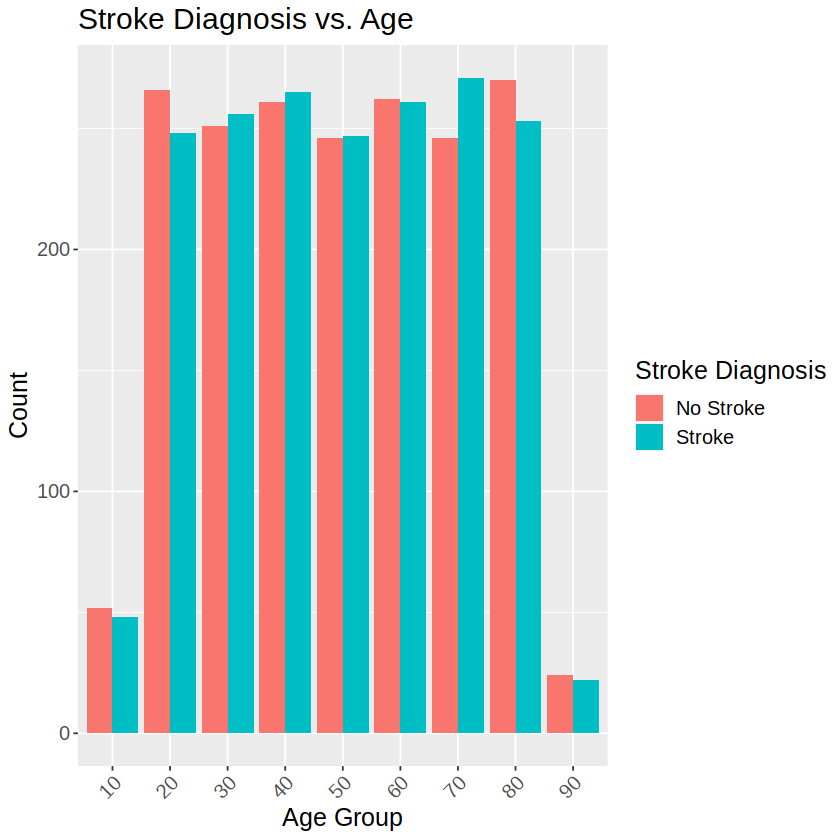

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


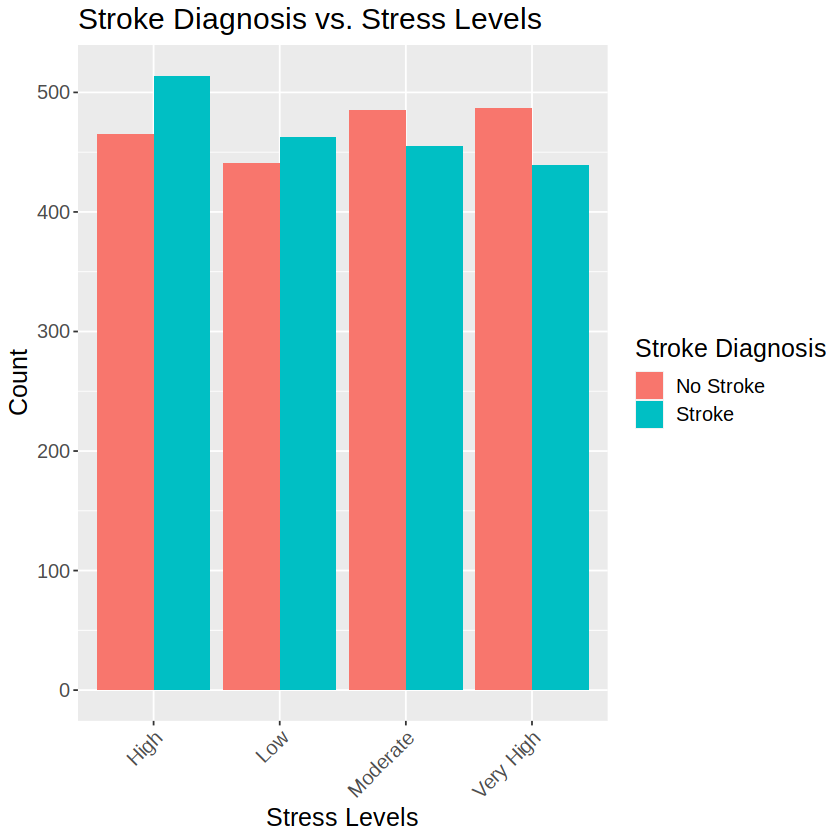

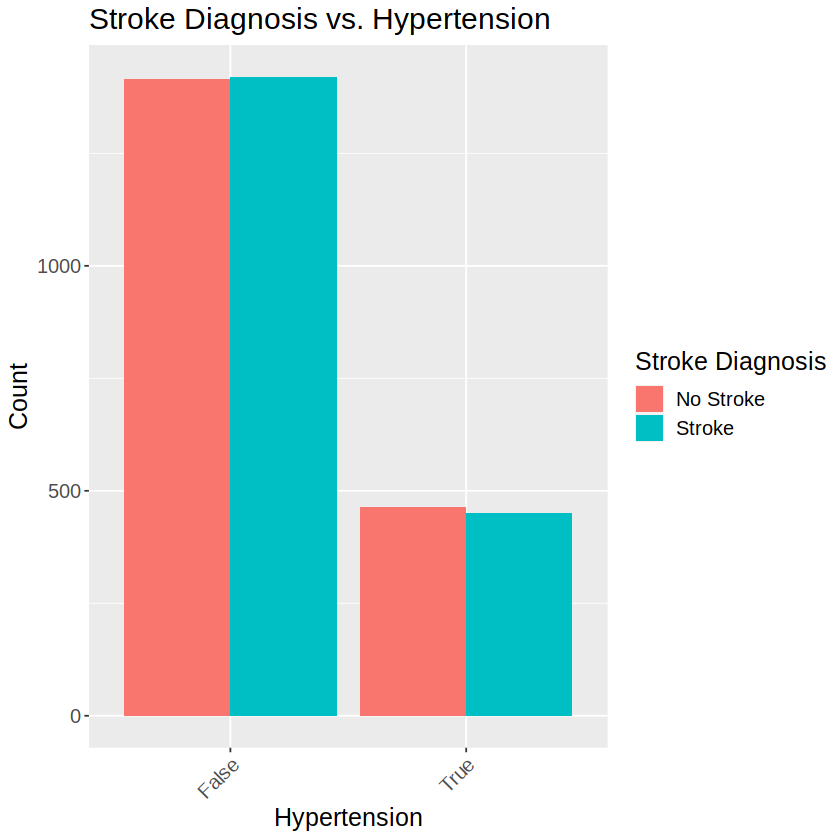

In [9]:
options(repr.plot.width = 7, repr.plot.height = 7)

stroke_marital <- stroke_training |>
            ggplot(aes(x = marital_status, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Marital Status", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Marital Status") +
            theme(text = element_text(size = 20)) +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_marital


stroke_work <- stroke_training |>
            ggplot(aes(x = work_type, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Work Type", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Work Type") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_work

stroke_residence <- stroke_training |>
            ggplot(aes(x = residence_type, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Residence Type", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Residence Type") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_residence

stroke_age <- stroke_training |>
            ggplot(aes(x = age_group, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Age Group", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Age") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_age

stroke_stress <- stroke_training |>
            ggplot(aes(x = stress_level_category, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Stress Levels", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Stress Levels") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_stress

stroke_hyper <- stroke_training |>
            ggplot(aes(x = hypertension, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Hypertension", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Hypertension") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_hyper


We made a histogram for hypertension to compare the number of people with and without hypertension who have suffered from a stroke. Although we had hypothesized that abnormal blood pressure levels could affect a persons risk of getting a stroke, we weren’t expecting this kind of outcome. If a person doesn’t have hypertension, they are more likely to get a stroke than a person who does. In fact, more people with hypertension don’t get strokes than those who do.

**Methods:**

Our dataset contains 19 predictors for stroke probability. We will use age, stress levels, hypertension, marital status, and residence type for prediction. We think all of these variables will be useful for prediction as from outside research, blood pressure levels (hence hypertension), stress levels, and age are causes of strokes. Variables such as marital status and residence type also can affect these variables, and seem to have a tangible difference for diagnosis as seen from the bar plots. Since we are using multiple predictors, we have no way to visualize it on a 2D plane. 

With the following predictors, we will be allowed to create a model and recipe to use the k-nearest neighbors algorithm to conduct a prediction. To increase the accuracy of the prediction, we will do a cross validation (i.e. vfold_cv()).  

**Expected Outcomes and Significance:**


We expect to find correlation between some of theses variables, and that all the variables play a big part in predicting strokes. Some of these variables lead to outside factors such as economic status and mental wellbeing, etc. If we can accurately predict strokes based on these variables, it can prove the connection between personal wellbeing and strokes, which can influence policies aimed for health. This can also lead to future questions such as to what extent is there correlation between these variables and others outside the scope of our project, and how could that influence the prediction of strokes. 